In [1]:
import sys
sys.path.append("../physiology/")
sys.path.append("../../")
sys.path.append("/home/ec2-user/marineHeatWaves/")
import tpc
import marineHeatWaves
from marineHeatWaves import detect


from mhw_pipeline.load_sst import OISST
from mhw_pipeline.detect import MHWDetector

import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import matplotlib.dates as mdates
import seaborn as sns


from functools import partial

import pandas as pd
import xarray as xr
import gcsfs
import s3fs
import numpy as np
import zarr


import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


from dask.distributed import Client


In [2]:
from importlib import reload
from mhw_pipeline import detect as mhdetect
reload(mhdetect)
reload(tpc)

<module 'tpc' from '../physiology/tpc.py'>

In [3]:
dask_client = Client()

# Individual MHW Event Visualization

Tony Cannistra, May 2020

**Purpose**: To create a multi-panel figure describing the *spatial*, *temporal*, and *physiological* characteristics of a given marine heatwave event, to illustrate the phenomena being aggregated in later portions of the analysis. 

## **Part 1:** Selection of isolate to visualize

Possible Approaches: 
* Find isolates that overlap with known MHW events for context 
* Find isolates experiencing particularly "dramatic" shifts in performance due to MHW events. 

In [4]:
isolates = pd.read_csv(
    "../../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv",
    engine='python'
)
isolates = isolates[
    (isolates.habitat == 'marine') & 
    (isolates.curvequal == 'good')
]

In [5]:
mhwPerformance_aggregated = pd.read_csv(
    "../isolate_performance_withnegative.csv"
)

In [6]:
mhwPerformance_all = xr.open_zarr(store='../../data/isolate_mhw_performance.zarr', group="isolate_mhw_performance.zarr",)

In [7]:
oisst = OISST("../../gc-pangeo.json")
oisst = oisst.load()

Define some "known MHWs" from Hobday et al, 2016:

In [8]:
known_mhws = {
    'WA2011' : {
        'name' : 'Western Australia 2011',
        'start': '2010-10-01',
        'end' : '2011-08-31',
        'focal' : '2001-02-28',
        'lat_min' : -35.,
        'lat_max' : -23.,
        'lon_min' : 95.,
        'lon_max' : 120.
    }, 
    'MED2003' : {
        'name' : 'Mediterranean 2003',
        'start' : '2003-01-01',
        'end' : '2003-12-31',
        'focal' : '2003-06-20',
        'lat_min' : 34.,
        'lat_max' : 46.,
        'lon_min' : 0.,
        'lon_max' : 25.
    },
    'NWA2012' : {
        'name' : 'Northwest Atlantic 2012',
        'start' : '2011-12-01',
        'end' : '2012-11-01',
        'lat_min' : 36.,
        'lat_max' : 50.,
        'lon_min' : -80., 
        'lon_max': -55.,
        'focal': '2012-05-20'
    },
    'NEPacW2014' : {
        'name': "Northeast Pacific Winter 2013/14", 
        'start': "2013-10-01",
        'end' : '2014-06-01',
        'lat_min': 32.,
        'lat_max': 60.,
        'lon_min': -175.,
        'lon_max': -120.,
        'focal': '2014-02-15' # feb 15?
    },
    'NEPacW2015' : {
        'name': "Northeast Pacific Winter 2015/15", 
        'start': "2014-10-01",
        'end' : '2015-06-01',
        'lat_min': 32.,
        'lat_max': 60.,
        'lon_min': -175.,
        'lon_max': -120.,
        'focal': '2015-02-15' # feb 15?
    },
}
CHOSEN_MHW_ID = 'MED2003'
CHOSEN_MHW = known_mhws[CHOSEN_MHW_ID]

In [9]:
CHOSEN_MHW

{'name': 'Mediterranean 2003',
 'start': '2003-01-01',
 'end': '2003-12-31',
 'focal': '2003-06-20',
 'lat_min': 34.0,
 'lat_max': 46.0,
 'lon_min': 0.0,
 'lon_max': 25.0}

Do we have MHW detections for any phytoplankton in this region?

In [10]:
focal_isolates = isolates[
    (isolates['isolation.latitude'].between(CHOSEN_MHW['lat_min'], CHOSEN_MHW['lat_max'])) & 
    (isolates['isolation.longitude'].between(CHOSEN_MHW['lon_min'], CHOSEN_MHW['lon_max']))
]

In [11]:
focal_isolates

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
162,232,"Gulf of Marseille, Mediterranean Sea",43.32,5.32,marine,Prorocentrum minimum,Prorocentrum minimum,NaN,NaN,NaN,...,good,good,good,-200.217929,-0.013979,1.0,1.0,1.0,1.0,1.0
398,543,"Gulf of Naples, Italy",40.75,14.33,marine,Thalassiosira rotula strain CCMP1647,Thalassiosira rotula,NaN,NaN,CCMP1647,...,good,good,good,-300.814304,-0.017081,1.0,1.0,1.0,1.0,1.0
399,544,"Gulf of Naples, Italy",40.49,14.14,marine,Thalassiosira rotula strain CCMP3264,Thalassiosira rotula,NaN,NaN,CCMP3264,...,good,good,good,-309.766019,-0.012502,1.0,1.0,1.0,1.0,1.0


Pick a single isolate to look at:

In [12]:
chosen_isolate = 162

In [13]:
focal_heatwaves = mhwPerformance_aggregated[mhwPerformance_aggregated.isolate == focal_isolates.loc[chosen_isolate]['isolate.code']]

In [14]:
len(focal_heatwaves)

76

We'll see if any of these `focal_heatwaves` overlap with the actual `CHOSEN_MHW`:

In [15]:
focal_heatwaves.peak_date = pd.to_datetime(focal_heatwaves.peak_date)
focal_heatwaves[
    focal_heatwaves.peak_date.between(CHOSEN_MHW['start'], CHOSEN_MHW['end'])
]

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,Unnamed: 0,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins
1072,1072,43.375,5.375,232,12.0,1.901425,0.388513,0.271632,0.113875,0.079617,...,1.398930,8.0,1,2,16.834713,2002-12-30,2003-01-02,0.773172,"(31.0, 46.125]","(0.639, 91.25]"
1900,1900,43.375,5.375,232,14.0,0.135400,0.016138,0.011283,0.144456,0.100997,...,3.573529,13.0,157,164,17.681864,2003-06-06,2003-06-13,0.093096,"(31.0, 46.125]","(91.25, 181.5]"
4738,4738,43.375,5.375,232,13.0,5.656348,0.449457,0.314242,0.104354,0.072960,...,1.244200,19.0,12,19,17.681864,2003-01-12,2003-01-19,0.811151,"(31.0, 46.125]","(0.639, 91.25]"
5002,5002,43.375,5.375,232,15.0,1.143704,0.060586,0.042359,-0.045928,-0.032111,...,3.770523,28.0,216,226,17.681864,2003-08-04,2003-08-14,4.764687,"(31.0, 46.125]","(181.5, 271.75]"


Ok, some do (for MED2003...). Do we have the exact mhw? (by peak?)

In [16]:
focal_heatwaves['focal_peak_difference'] = abs(pd.to_datetime(focal_heatwaves.peak_date) - pd.to_datetime(CHOSEN_MHW['focal']))
closest_heatwave = focal_heatwaves.sort_values(by='focal_peak_difference', ascending=True).head(1)
closest_heatwave

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_mean,performance_diff_unscaled_mean,...,duration,start_doy,peak_doy,current_year_sst_mean,start_date,peak_date,perf_det_ratio,latbin,doy_bins,focal_peak_difference
1900,1900,43.375,5.375,232,14.0,0.1354,0.016138,0.011283,0.144456,0.100997,...,13.0,157,164,17.681864,2003-06-06,2003-06-13,0.093096,"(31.0, 46.125]","(91.25, 181.5]",7 days


In [17]:
isolates[isolates['isolate.code']==closest_heatwave.isolate.values[0]]

,isolate.code,source,isolation.latitude,isolation.longitude,habitat,name,speciesname,former.name.1,former.name.2,strain,...,minqual,maxqual,curvequal,abs.curveskew,rel.curveskew,used.for.optimum.analysis,used.for.tmax.analysis,used.for.tmin.analysis,used.for.niche.width.analysis,used.for.max.growth.rate.analysis
162,232,"Gulf of Marseille, Mediterranean Sea",43.32,5.32,marine,Prorocentrum minimum,Prorocentrum minimum,NaN,NaN,NaN,...,good,good,good,-200.217929,-0.013979,1.0,1.0,1.0,1.0,1.0


In [18]:
from importlib import reload
from mhw_pipeline import detect as mhdetect
reload(mhdetect)


<module 'mhw_pipeline.detect' from '../../mhw_pipeline/detect.py'>

### **1.1**: Detect regional MHWs

In [19]:
regional_sst = oisst.sel(
    lat = slice(CHOSEN_MHW['lat_min'], CHOSEN_MHW['lat_max']), 
    lon = slice(CHOSEN_MHW['lon_min'], CHOSEN_MHW['lon_max']),
)
detector = mhdetect.MHWDetector(regional_sst)

In [20]:
detections = detector.detect().compute()


In [21]:
detections = detections.chunk({'lat': 5, 'lon': 5, 'time': -1})

In [22]:
## save to s3 
fs = s3fs.S3FileSystem()
s3_store = s3fs.S3Map(f"s3://mhw-stress/{CHOSEN_MHW_ID}_mhw_detections/", s3=fs, check=False)
compressor = zarr.Blosc(cname='zstd', clevel=3)
encoding = {vname: {'compressor': compressor} for vname in detections.data_vars}
detections.to_zarr(s3_store, encoding=encoding, consolidated=True, mode='w')

### **1.2**: Compute Regional Performance for Individual Isolate

In [23]:
def compute_performance_reigonal(isolate, regional_sst, regional_mhws):
    _tpc = partial(
        tpc.tpc,
        a=isolate['mu.alist'], b=isolate['mu.blist'], z=isolate['mu.c.opt.list'], w=isolate['mu.wlist']
    )
    
    tmin_col = 'tmin'
    tmax_col = 'tmax'
    topt_col = 'mu.g.opt.list'
    
    _tmin = isolate[tmin_col]
    _tmax = isolate[tmax_col]
    _topt = isolate[topt_col]
    values = xr.apply_ufunc(
        _tpc,
        regional_sst.chunk({'lat': 5, 'lon': 5, 'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).sst.T
    
    
        
    performance = xr.full_like(regional_sst, fill_value=0.).rename_vars({'sst' : "performance"})
    performance['performance_clim'] = xr.zeros_like(performance.performance)
    performance['topt'] = xr.zeros_like(performance.performance)
    performance['tmin'] = xr.zeros_like(performance.performance)
    performance['tmax'] = xr.zeros_like(performance.performance)
    performance.attrs = {}
    
    values_clim = xr.apply_ufunc(
        _tpc,
        regional_mhws.clim_seas.chunk({'lat': 5, 'lon': 5, 'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).T
    
    performance['performance'] = values
    
    performance['performance_clim'] = values_clim
    
    performance['topt'] = _topt
    
    performance['tmin'] = _tmin
    
    performance['tmax'] = _tmax
    
    return(performance.assign_coords(isolate = isolate['isolate.code']))
    


    

In [24]:
regional_performance = compute_performance_reigonal(focal_isolates.iloc[0], regional_sst, detections).persist()

In [25]:
regional_mhws = xr.merge([detections, regional_performance])

In [26]:
regional_mhws

,Array,Chunk
Bytes,523.62 MB,2.73 MB
Shape,"(48, 100, 13636)","(5, 5, 13636)"
Count,201 Tasks,200 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,523.62 MB,2.73 MB
Shape,"(48, 100, 13636)","(5, 5, 13636)"
Count,201 Tasks,200 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


## **Section 2:** Plots

### Helper Functions



In [27]:
def finish_geoaxes(ax):
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right =False
    gl.xlines = True
#     gl.xlocator = mticker.FixedLocator(np.arange(mhw['lat_min'], mhw['lat_max']))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'size': 15, 'color': 'gray'}
#     gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


### Start with a Locator Map
* Contains MHW region
* Shows SST anomaly at `peak`
* Gridlines, coastlines, labels, etc

In [28]:
# TODO: Put ANOMALY here not SST plain!!!!

def mhw_locator_map(mhw, sst, detections, peak=None, ax=None, cbar_ax=None):
    PROJECTION = ccrs.Mercator()
    if ax is None:
        ax = plt.axes(projection=PROJECTION)

    if peak is None:
        peak = mhw['focal']
        
    selector = dict(
        lat = slice(mhw['lat_min'], mhw['lat_max']), 
        lon = slice(mhw['lon_min'], mhw['lon_max']),
        time = peak
    )
        
    these_sst = sst.sel(**selector)
    these_detections = detections.sel(**selector)
#     these_clim = clim.sel(time = selector['time'])
    
#     print(these_sst)
#     print(these_clim)
    
    anomaly = these_sst.sst - these_detections.clim_seas
    
    cbar_options = dict(shrink=0.9, ticks=np.arange(0, 9), format="%d", extend='neither', label='SST Anomaly [degC]')
    axes = anomaly.plot.contourf(
        ax=ax,
        transform=ccrs.PlateCarree(),
        levels=15, vmin=0, vmax=7, cmap='gist_heat_r',
        cbar_kwargs=cbar_options, cbar_ax=cbar_ax, extend='neither',
    )

    finish_geoaxes(ax)

    ax.set_title("")
    datestr = pd.to_datetime(peak).strftime("%d %B %Y")
    ax.annotate(datestr, (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')
    return(ax)

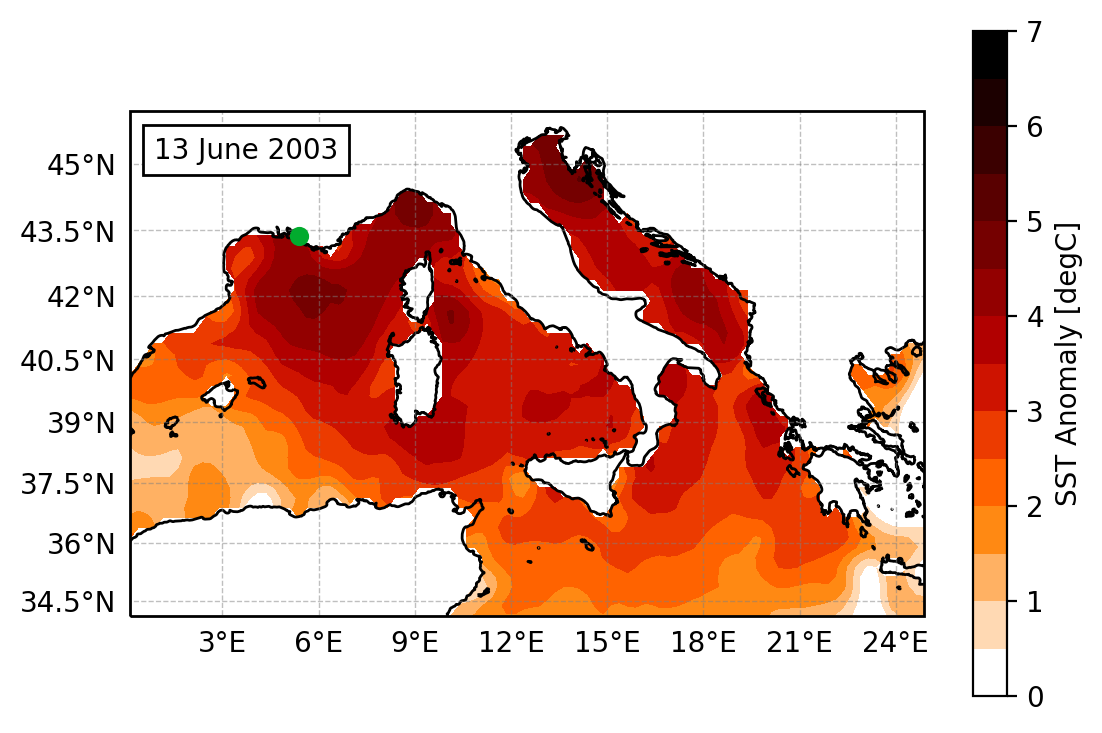

In [33]:
fig = plt.figure(dpi=200)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)
plt.style.use('default')
a = mhw_locator_map(CHOSEN_MHW, oisst, detections, peak='2003-06-13')
a.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='xkcd:kelly green', s=35, marker='o', zorder=10)

plt.savefig(f"{CHOSEN_MHW['name'].replace(' ', '_')}_sst_anomaly.png", dpi=300, bbox_inches='tight', transparent=True)

## Now build SST Anomaly Plots

*helper function for dates:*

In [34]:
def format_date_axis(ax):
#     locator = mdates.AutoDateLocator(minticks=3, maxticks=10)
    locator = mdates.MonthLocator()
#     locator.intervald['MONTHLY'] = [2]
    formatter = mdates.DateFormatter("%b %Y")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    ax.tick_params(direction='in', top=True, right=True)
    

Helper Functions for MHW Bands

In [35]:
def add_mhw_bands(performance, oisst, ax):
    mhw_bands = performance.where(performance.mhw > 0, drop=True)
    mhw_band_starts = oisst.time.values[np.unique(mhw_bands.index_start).astype('int')]
    mhw_band_ends = oisst.time.values[np.unique(mhw_bands.index_end).astype('int')]
    [ax.axvspan(start, end, color='grey', alpha=0.2, zorder=-1) for start, end in zip(mhw_band_starts, mhw_band_ends)]

In [36]:
def mhw_sst(mhw, lat, lon, sst, clim, ax=None):
    if ax is None:
        plt.figure(dpi=150)
        ax = plt.axes()
    
    selector = dict(
        lat = lat, 
        lon = lon,
        time = slice(mhw['start'], mhw['end'])
    )
        
    these_sst = sst.sel(**selector)
    these_clim = clim.sel(time=selector['time'])
    
    these_sst.sst.plot(ax=ax, color='black', label='SST')
    these_clim.clim_seas.plot(ax=ax, color='blue', label='Climatology')
    these_clim.clim_thresh.plot(ax=ax, color='green', label='Threshold')

    warm_mask = (these_clim.mhw > 0).values.ravel()
    
    ax.fill_between(
        x =these_clim.time.values, 
        y1= these_clim.clim_thresh.values.ravel(), 
        y2=these_sst.sst.values.ravel(),
        where=warm_mask, 
        color='red'
    )
    
    ax.set_title("")
    ax.legend(loc='lower center', ncol=3)
    ax.set_ylabel("[$^\circ$C]")
    ax.set_xlim(mhw['start'], mhw['end'])
    ax.annotate("Marine Heatwave Anomalies", (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')
    
    ax.set_facecolor('white')
    format_date_axis(ax)

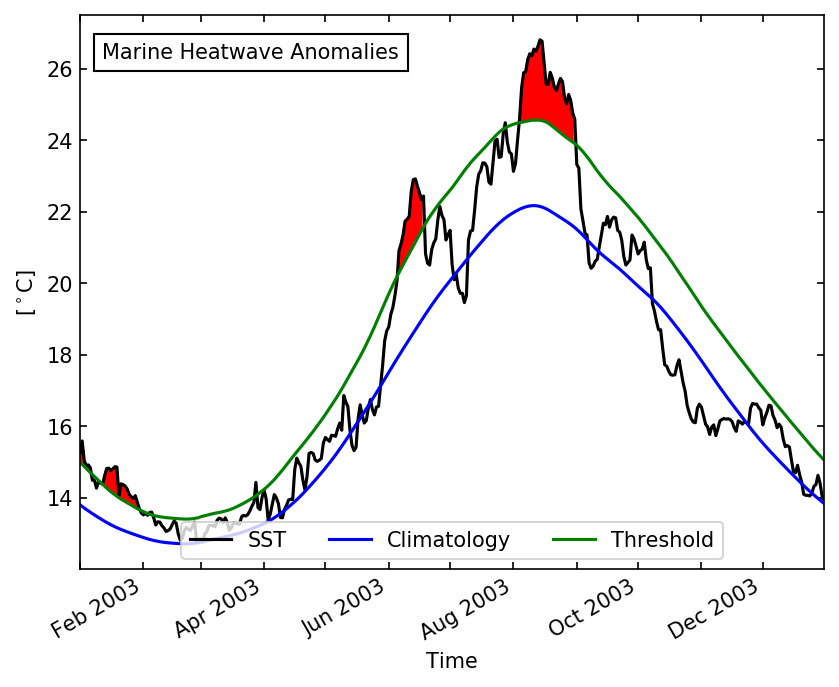

In [38]:
# plt.style.use('dark_background')
mhw_sst(CHOSEN_MHW, closest_heatwave.lat, closest_heatwave.lon, oisst, mhwPerformance_all.sel(isolate=closest_heatwave.isolate.values))
plt.savefig(f"{CHOSEN_MHW['name'].replace(' ', '_')}_mhws_time.png", dpi=300, bbox_inches='tight', transparent=True)

## Now the Physiology:

**First:** add the "anomaly" plot with performance deteriment + stuff


In [39]:
def physio_anomalies(isolate, mhw, lat, lon, performance, sst, ax=None): 
    if ax is None:
        plt.figure(dpi=150),
        ax = plt.axes()
        
    selector = dict(
        lat = lat, 
        lon = lon,
        time = slice(mhw['start'], mhw['end'])
    )
        
    these_sst = sst.sel(**selector)
    these_performance = performance.sel(time=selector['time'])
    
#     these_sst.sst.plot(ax=ax, color='black', alpha=0.3, label='SST')
    
    
#     these_performance.clim_seas.plot(ax=ax, color='blue', alpha=0.3, label='Climatology')
#     these_performance.clim_thresh.plot(ax=ax, color='green', alpha=0.3, label='Threshold')

#     warm_mask = (these_performance.mhw > 0).values.ravel()
    
#     ax.fill_between(
#         x =these_performance.time.values, 
#         y1= these_performance.clim_thresh.values.ravel(), 
#         y2=these_sst.sst.values.ravel(),
#         where=warm_mask, 
#         color='red', 
#         alpha=0.3
#     )

    performance_ax = ax
#     l = these_performance.performance / these_performance.performance_clim
#     performance_ratio.plot(ax=performance_ax)
    scale = tpc.physiological_scaler(isolate)
    performance_diff = scale(these_performance.performance - these_performance.performance_clim)
    performance_ax.set_ylim([-0.5, 0.5])
    performance_ax.set_title("")
    performance_ax.set_ylabel('Scaled Performance Diff.')

#     positive_ratio = (performance_ratio > 1).values.ravel()
#     negative_ratio = (performance_ratio < 1).values.ravel()

    positive_diff = (performance_diff > 0).values.ravel()
    negative_diff = (performance_diff < 0).values.ravel()
    
    add_mhw_bands(these_performance, oisst, ax=performance_ax)
    
    performance_ax.fill_between(
        performance_diff.time.values.ravel(), 
        0, 
        performance_diff.values.ravel(),
        where = positive_diff,
        color='xkcd:kelly green'
    )
    
    performance_ax.fill_between(
        performance_diff.time.values.ravel(), 
        0, 
        performance_diff.values.ravel(),
        where = negative_diff,
        color='xkcd:brick red'
    )
    
    performance_ax.axhline(0.0, alpha=1, linestyle='--', color='red')

    ax.set_xlim(mhw['start'], mhw['end'])
    
    ax.annotate("Performance Difference",  (0.04, 0.93), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')
    
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
    
    format_date_axis(ax)


../physiology/tpc.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  max_performance = physio_data['mu.g.opt.val.list'].item() # max growth rate


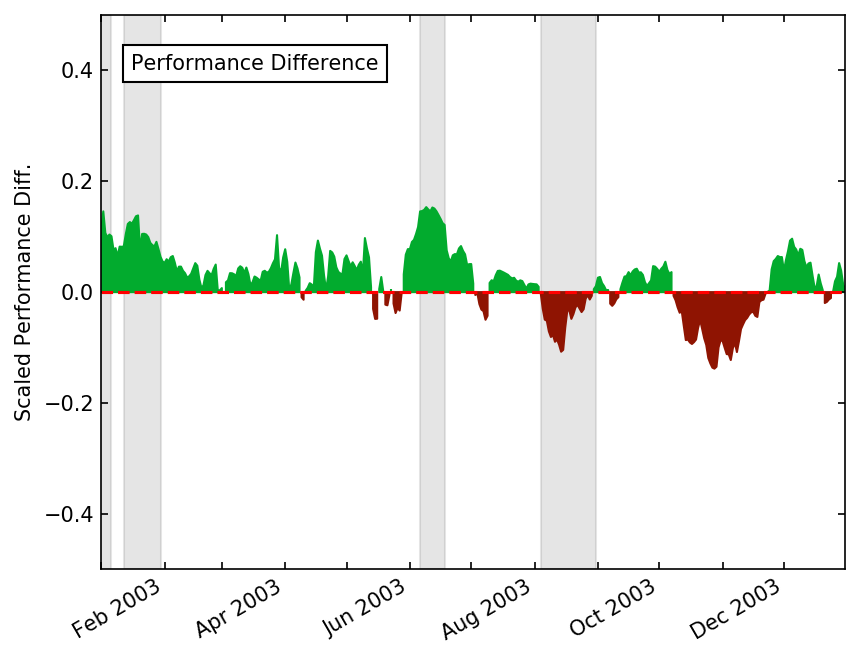

In [40]:
physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst
)
plt.savefig(f"{CHOSEN_MHW['name'].replace(' ', '_')}_physio_anomaly_time.png", dpi=300, bbox_inches='tight')


In [91]:
def map_physio_anomalies(isolate, mhw, regional_performance, mhw_peak_time, focal_lat, focal_lon, sst, ax=None):
    if ax is None:
        plt.figure(dpi=150)
        ax = plt.axes(projection=ccrs.Mercator().GOOGLE)
    
    mhw_id = regional_performance.sel(time=mhw_peak_time, lat=focal_lat, lon=focal_lon).mhw.values[0]
    mhw_times = regional_performance.sel(lat=focal_lat, lon=focal_lon).where(regional_performance.mhw == mhw_id[0], drop=True).time
    mhw_start = mhw_times.min()
    mhw_end = mhw_times.max()
    
    regional_mhw_data = regional_performance.sel(
        time=slice(mhw_start, mhw_end)
    )
#     
    performance_anomaly = regional_mhw_data.performance - regional_mhw_data.performance_clim
    print(performance_anomaly)
    
    vmin = -0.5
    vmax=0.5
    levels=7
    cbar_options = dict(shrink=0.9, ticks=np.linspace(vmin, vmax, num=levels/2), format="%.2f", extend='neither', label='Scaled Performance Diff.')

    performance_anomaly.mean(dim='time').plot.contourf(
        ax=ax, x='lon', y='lat', 
        cmap="RdYlGn", 
        cbar_kwargs=cbar_options, transform=ccrs.PlateCarree(), 
        vmin=vmin, vmax=vmax, levels=levels, extend='both')
    
    plt.title("")
    datestr = pd.to_datetime(mhw_peak_time).strftime("%d %B %Y")
    ax.annotate(datestr, (0.03, 0.95), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'))
    
    finish_geoaxes(ax)

<xarray.DataArray (time: 12, lon: 100, lat: 48)>
dask.array<sub, shape=(12, 100, 48), dtype=float64, chunksize=(12, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 34.125 34.375 34.625 34.875 ... 45.375 45.625 45.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 24.375 24.625 24.875
  * time     (time) datetime64[ns] 2003-06-06 2003-06-07 ... 2003-06-17
    isolate  int64 232


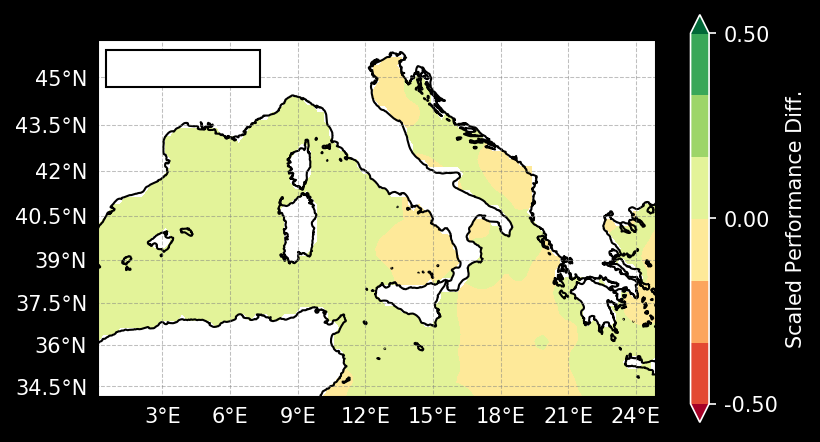

In [161]:
map_physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW,
    regional_mhws,
    '2003-06-15',
    closest_heatwave.lat, 
    closest_heatwave.lon,
    oisst
)

In [41]:
def mhw_performance(isolate, mhw, lat, lon, performance, sst, ax=None):
    if ax is None:
        plt.figure(dpi=150)
        ax = plt.axes()
    
    selector = dict(
        lat = lat, 
        lon = lon,
        time = slice(mhw['start'], mhw['end'])
    )
        
    these_sst = sst.sel(**selector)
    these_performance = performance.sel(time=selector['time'])

    good_performance = these_performance.performance > these_performance.performance_clim
    bad_performance = these_performance.performance < these_performance.performance_clim
    
#     these_performance.performance.plot(ax=ax, color='white',linewidth=0.5,)
    these_performance.performance_clim.plot(ax=ax, color='blue', label='Average Perf.')
    
    add_mhw_bands(these_performance, oisst, ax=ax)
    
    ax.fill_between(
        these_performance.time.values.ravel(),
        these_performance.performance_clim.values.ravel(), 
        these_performance.performance.values.ravel(),
        where=good_performance.values.ravel(),
        color='xkcd:kelly green', 
        label="Better Perf."
    )
    
    ax.fill_between(
        these_performance.time.values.ravel(),
        these_performance.performance_clim.values.ravel(), 
        these_performance.performance.values.ravel(),
        where=bad_performance.values.ravel(),
        color='xkcd:brick red', 
        label='Worse Perf.'
    )
    
#     ax.set_ylim([0, 1])
    ax.set_ylabel("Performance [Growth Rate]")
    ax.set_xlim(mhw['start'], mhw['end'])
    ax.legend(loc='lower center', ncol=3)
    ax.set_title("")
    ax.annotate("Performance Anomalies", (0.04, 0.93), xycoords='axes fraction', ha='left', va='top',
                bbox=dict(facecolor='w', edgecolor='k'), color='k')
    ax.set_ylim([0, 1])
    
    format_date_axis(ax)

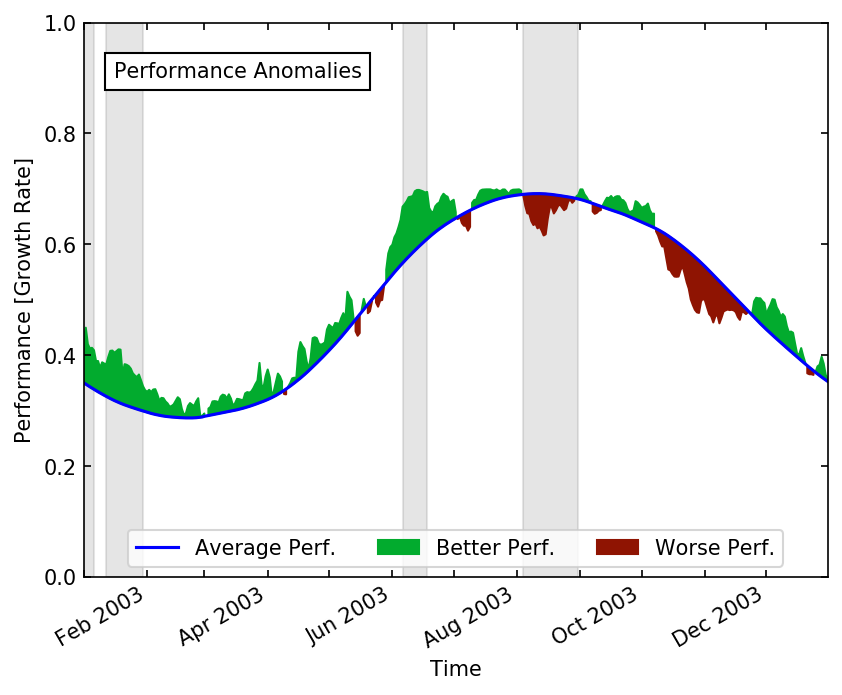

In [42]:
mhw_performance(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst
)
plt.savefig(f"{CHOSEN_MHW['name'].replace(' ', '_')}_physio_time.png", dpi=300, bbox_inches='tight')


### Bring Physiology Plots Together

../physiology/tpc.py:12: FutureWarning: `item` has been deprecated and will be removed in a future version
  max_performance = physio_data['mu.g.opt.val.list'].item() # max growth rate


<xarray.DataArray (time: 13636, lon: 220, lat: 112)>
dask.array<sub, shape=(13636, 220, 112), dtype=float64, chunksize=(13636, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.125 32.375 32.625 32.875 ... 59.375 59.625 59.875
  * lon      (lon) float32 -174.875 -174.625 -174.375 ... -120.375 -120.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
    isolate  int64 169
<xarray.DataArray (time: 13636, lon: 220, lat: 112)>
dask.array<sub, shape=(13636, 220, 112), dtype=float64, chunksize=(13636, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 32.125 32.375 32.625 32.875 ... 59.375 59.625 59.875
  * lon      (lon) float32 -174.875 -174.625 -174.375 ... -120.375 -120.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
    isolate  int64 169


/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


FileNotFoundError: [Errno 2] No such file or directory: 'Northeast_Pacific_Winter_2013/14_performance.pdf'

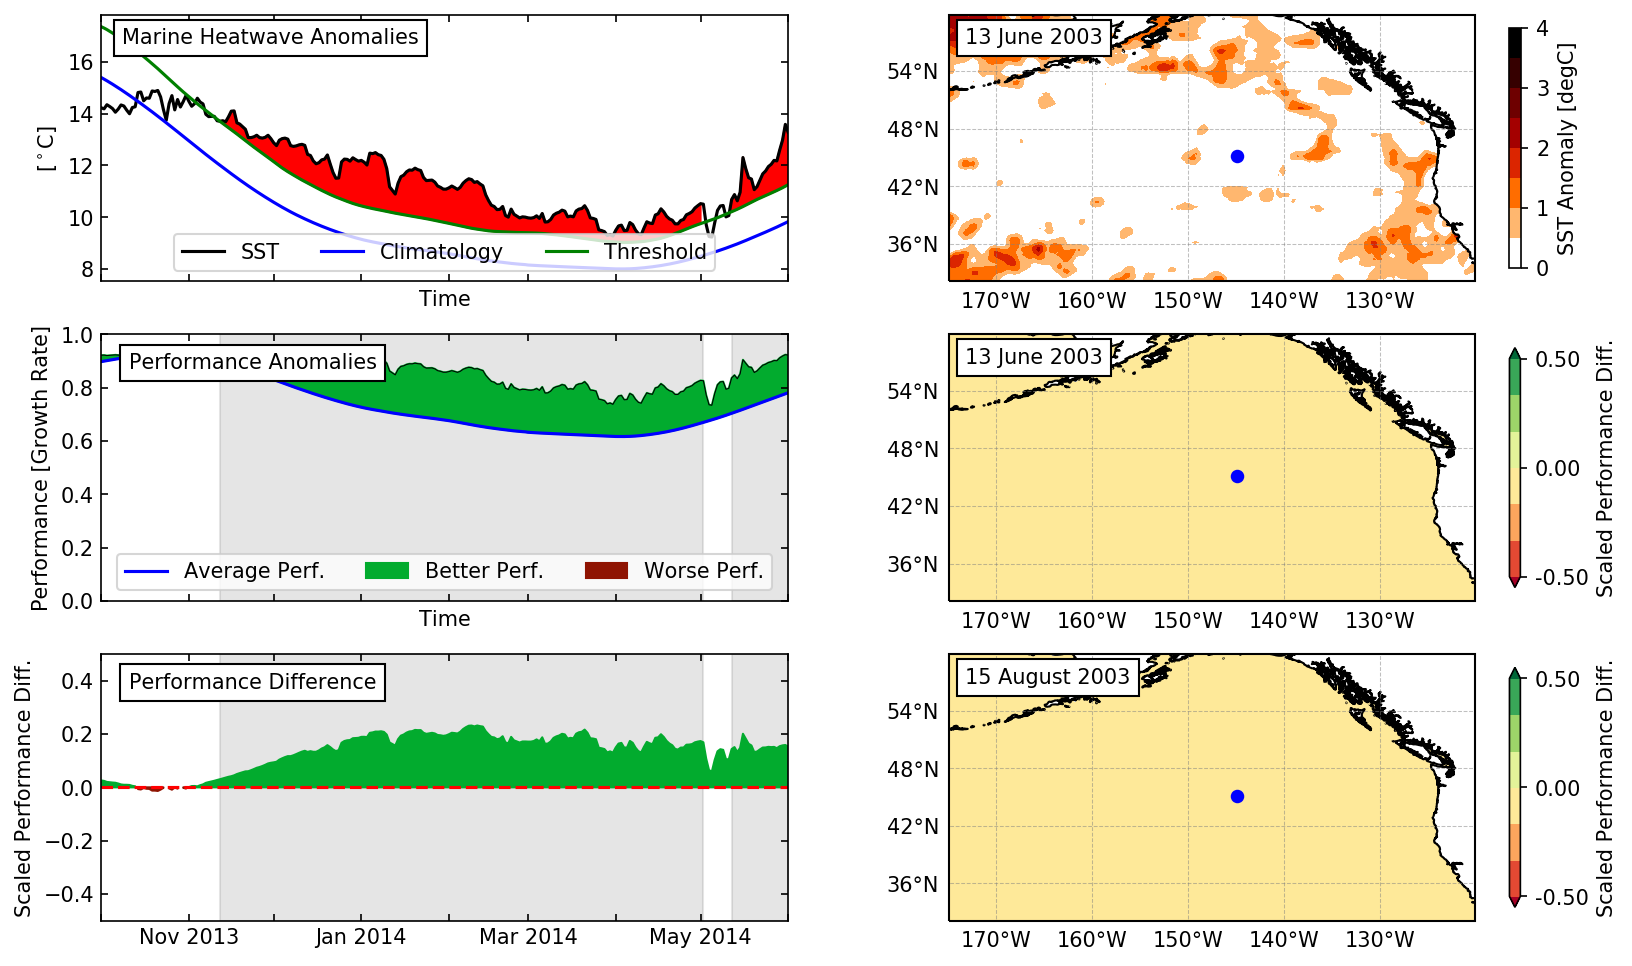

In [95]:
fig = plt.figure(dpi=150, figsize=(13, 8))
grid = fig.add_gridspec(3, 2)

# fig, axes = plt.subplots(3, 1, dpi=150, figsize=(5.5, 7), sharex=True)

sst_ax = fig.add_subplot(grid[0, 0])
mhw_sst(CHOSEN_MHW, closest_heatwave.lat, closest_heatwave.lon, oisst, mhwPerformance_all.sel(isolate=closest_heatwave.isolate.values),ax=sst_ax)
sst_ax.tick_params(labelbottom=False)

perf_ax = fig.add_subplot(grid[1, 0], sharex=sst_ax)
mhw_performance(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst,
    ax=perf_ax
)
perf_ax.tick_params(labelbottom=False)

physio_ax = fig.add_subplot(grid[2, 0], sharex=sst_ax)
physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst,
    ax=physio_ax
)

map_ax = fig.add_subplot(grid[0, 1], projection=ccrs.PlateCarree())
a = mhw_locator_map(CHOSEN_MHW, oisst, detections, ax=map_ax, peak='2003-06-13')
map_ax.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='blue', s=30)

physio_map_ax = fig.add_subplot(grid[1, 1], projection=ccrs.PlateCarree())
map_physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW,
    regional_mhws,
    '2003-06-13',
    closest_heatwave.lat, 
    closest_heatwave.lon,
    oisst,
    ax=physio_map_ax,
    
)
physio_map_ax.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='blue', s=30)


physio_map_ax = fig.add_subplot(grid[2, 1], projection=ccrs.PlateCarree())
map_physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW,
    regional_mhws,
    '2003-08-15',
    closest_heatwave.lat, 
    closest_heatwave.lon,
    oisst,
    ax=physio_map_ax,
    
)
physio_map_ax.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='blue', s=30)



plt.tight_layout()
plt.savefig(f"{CHOSEN_MHW['name'].replace(' ','_')}_performance.pdf", bbox_inches='tight')

NameError: name 'mhw_locator_map' is not defined

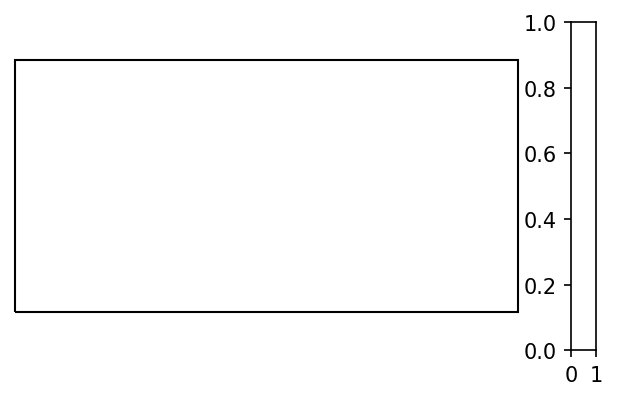

In [16]:
fig = plt.figure(dpi=150, figsize=(5, 10))
grid = fig.add_gridspec(4, 1, height_ratios=[1.5, 1, 1, 1])

# fig, axes = plt.subplots(3, 1, dpi=150, figsize=(5.5, 7), sharex=True)

map_sgs = grid[0, 0].subgridspec(1, 2, width_ratios=[1, 0.05])
map_ax = fig.add_subplot(map_sgs[0, 0], projection=ccrs.PlateCarree())
cbar_ax = fig.add_subplot(map_sgs[0, 1])
a = mhw_locator_map(CHOSEN_MHW, oisst, detections, ax=map_ax, cbar_ax = cbar_ax)
map_ax.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='blue', s=30)

sst_ax = fig.add_subplot(grid[1, 0])
mhw_sst(CHOSEN_MHW, closest_heatwave.lat, closest_heatwave.lon, oisst, mhwPerformance_all.sel(isolate=closest_heatwave.isolate.values),ax=sst_ax)

perf_ax = fig.add_subplot(grid[2, 0], sharex=sst_ax)
mhw_performance(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst,
    ax=perf_ax
)

physio_ax = fig.add_subplot(grid[3, 0], sharex=sst_ax)
physio_anomalies(
    isolates[isolates['isolate.code'] == closest_heatwave.isolate.values[0]], 
    CHOSEN_MHW, 
    closest_heatwave.lat, 
    closest_heatwave.lon, 
    mhwPerformance_all.sel(isolate = closest_heatwave.isolate.values),
    oisst,
    ax=physio_ax
)

# map_ax = fig.add_subplot(grid[:, 1], projection=ccrs.PlateCarree())
# a = mhw_locator_map(CHOSEN_MHW, oisst, detections, ax=map_ax)
# map_ax.scatter(closest_heatwave.lon, closest_heatwave.lat, transform=ccrs.PlateCarree(), c='blue', s=30)

plt.tight_layout()
plt.savefig(f"{CHOSEN_MHW['name'].replace(' ','_')}_vertical_performance.pdf", bbox_inches='tight')

In [ ]:
    mhw_bands = performance.where(performance.mhw > 0, drop=True)


-- some helpful stats

In [128]:
lat = closest_heatwave.lat
lon = closest_heatwave.lon

selector = dict(
    lat = lat, 
    lon = lon,
    time = slice(mhw['start'], mhw['end'])
)


these_performance = regional_mhws.sel(**selector)

In [160]:
start_dates = oisst.time.values[np.unique(these_performance.where(these_performance.mhw >0, drop=True).index_start).astype('int')]

set(zip(list(these_performance.intensity_mean.values.ravel()), list(these_performance.time.dt.month.values.ravel())))

{(0.0, 1),
 (0.0, 2),
 (0.0, 3),
 (0.0, 4),
 (0.0, 5),
 (0.0, 6),
 (0.0, 7),
 (0.0, 8),
 (0.0, 9),
 (0.0, 10),
 (0.0, 11),
 (0.0, 12),
 (1.2442004069407664, 1),
 (1.3989302996666229, 1),
 (3.5735291653768004, 6),
 (3.7705231108423747, 8)}

In [96]:
focal_heatwaves.sort_values('focal_peak_difference')[['peak_date', 'performance_diff_mean']]

,peak_date,performance_diff_mean
1900,2003-06-13,0.144456
5002,2003-08-14,-0.045928
4738,2003-01-19,0.104354
1072,2003-01-02,0.113875
1899,2002-06-23,0.107222
...,...,...
3947,2018-08-24,-0.029485
3206,2018-09-08,0.032027
2676,2018-10-13,0.084844
1902,2018-11-15,0.144636
